In [1736]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from random import randint

os.chdir("/home/william/Desktop")

In [1737]:
datosTicTacToe = pd.read_csv("tic-tac-toe.csv")

In [1738]:
for x in datosTicTacToe:
    if x != " Gana-x":
        datosTicTacToe[x] = datosTicTacToe[x].astype('category')
datosTicTacToe.dtypes

cuadro-superior-izquierdo     category
 cuadro-superior-medio        category
 cuadro-superior-derecho      category
 cuadro-medio-izquierdo       category
 cuadro-medio-medio           category
  cuadro-medio-derecho        category
 cuadro-inferior-izquierdo    category
 cuadro-inferior-medio        category
 cuadro-inferior-derecho      category
 Gana-x                         object
dtype: object

In [1739]:
datosTicTacToePosiblesResultados = list(set(datosTicTacToe.iloc[:, -1]))

In [1740]:
class PrediccionBase:
    def __init__(self, datos):
        self.__datos = self.cleaning(datos)
        self.__precisionGlobal = 0
        self.__error_global = 0
        self.__verdaderosNegativos = 0
        self.__falsosPositivos = 0
        self.__falsosNegativos = 0
        self.__verdaderosPositivos = 0
        self.__reporte = 0
        self.__precision_category = 0

    @property
    def datos(self):
        return self.__datos

    @property
    def reporte(self):
        return self.__reporte

    def cleaning(self, datos):
        datos = datos.replace({'x': 0, 'o': 1, 'b': 2})
        return datos

    def entrenamiento(self):
        pass

    def generacionReporte(self, nombreDelModelo):
        dict = {
            "Modelo": [nombreDelModelo],
            "Precision Global": [self.__precisionGlobal],
            "Error Global": [self.__error_global],
            "Verdaderos Positivos": [self.__verdaderosPositivos],
            "Verdaderos Negativos": [self.__verdaderosNegativos],
            "Falsos Negativos": [self.__falsosNegativos],
            "Falsos Positivos": [self.__falsosPositivos]}
        self.__reporte = pd.DataFrame(dict).join(self.__precision_category)

    def analsis(self, MC, modelo):
        self.__verdaderosNegativos, self.__falsosPositivos, self.__falsosNegativos, self.__verdaderosPositivos = MC.ravel()
        self.__precisionGlobal = np.sum(MC.diagonal()) / np.sum(MC)
        self.__error_global = 1 - self.__precisionGlobal
        self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
        self.__precision_category.columns = ["Precision Positiva (PP)", "Precision Negativa (PN)"]
        self.generacionReporte(modelo)
        return {"Matriz de Confusión": MC,
                "Precisión Global": self.__precisionGlobal,
                "Error Global": self.__error_global,
                "Precisión por categoría": self.__precision_category}


class PrediccionKNeighbors(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia_potenciacion = None
        self.__x_test = None

    @property
    def instancia(self):
        return self.__instancia_potenciacion

    @property
    def x_test(self):
        return self.__x_test

    def entrenamiento(self, nucleo="auto", n_neighbors=3, train_size=0.80, entrenamiento="KNeighbors"):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        X_train, self.__x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion = KNeighborsClassifier(n_neighbors=n_neighbors, algorithm=nucleo)
        self.__instancia_potenciacion.fit(X_train, y_train)
        prediccion = self.__instancia_potenciacion.predict(self.__x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, entrenamiento)
        # for k in indices:
        #     print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionADABoosting(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    @property
    def instancia(self):
        return self.__instancia_potenciacion

    @property
    def x_test(self):
        return self.__x_test

    def obtenerVariablesImportantes(self):
        importancia = self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10, 8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75, criterion="gini", splitter="best", min_samples_split=2,
                      entretenamiento="Bosques Aleatorios ADA Boosting"):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]
        self.__instancia = DecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=None,
                                                  criterion=criterion, splitter=splitter)
        self.__instancia_potenciacion = AdaBoostClassifier(base_estimator=self.__instancia,
                                                           n_estimators=100, random_state=0)
        self.__x_train, self.__x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train, y_train)
        prediccion = self.__instancia_potenciacion.predict(self.__x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, entretenamiento)
        # for k in indices:
        #     print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionXGBoosting(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    @property
    def x_test(self):
        return self.__x_test
    @property
    def instancia(self):
        return self.__instancia_potenciacion

    def obtenerVariablesImportantes(self):
        importancia = self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10, 8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75, n_estimators=10, random_state=0, min_samples_split=2,
                      entrenamiento="Bosques Aleatorios XG Boosting"):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]

        self.__instancia_potenciacion = GradientBoostingClassifier(n_estimators=n_estimators, random_state=n_estimators,
                                                                   min_samples_split=min_samples_split, max_depth=None)

        self.__x_train, self.__x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train, y_train)
        prediccion = self.__instancia_potenciacion.predict(self.__x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, entrenamiento)
        # for k in indices:
        #     print("\n%s:\n%s" % (k, str(indices[k])))


class PrediccionRandomForest(PrediccionBase):
    def __init__(self, datos):
        super().__init__(datos)
        self.__instancia = None
        self.__instancia_potenciacion = None
        self.__x_train = []

    @property
    def instancia(self):
        return self.__instancia_potenciacion

    @property
    def x_test(self):
        return self.__x_test

    def obtenerVariablesImportantes(self):
        importancia = self.__instancia_potenciacion.feature_importances_
        print(importancia)
        etiquetas = self.__x_train.columns.values
        y_pos = np.arange(len(etiquetas))
        plt.figure(figsize=(10, 8))
        plt.barh(y_pos, importancia, align='center', alpha=0.5)
        plt.yticks(y_pos, etiquetas)

    def entrenamiento(self, train_size=0.75, n_estimators=10, entrenamiento="Bosques Aleatorios"):
        x = self.datos.iloc[:, :-1]
        y = self.datos.iloc[:, -1]

        self.__instancia_potenciacion = RandomForestClassifier(n_estimators=n_estimators, random_state=0)

        self.__x_train, self.__x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0)
        self.__instancia_potenciacion.fit(self.__x_train, y_train)
        prediccion = self.__instancia_potenciacion.predict(self.__x_test)
        MC = confusion_matrix(y_test, prediccion)
        indices = self.analsis(MC, entrenamiento)
        # for k in indices:
        #     print("\n%s:\n%s" % (k, str(indices[k])))

In [1741]:
prediccionADABosting = PrediccionADABoosting(datos=datosTicTacToe)
prediccionADABosting.entrenamiento(train_size=0.80)

[0.11262988 0.07880623 0.08039373 0.10569753 0.14000401 0.11100015
 0.15328041 0.09697945 0.12120859]


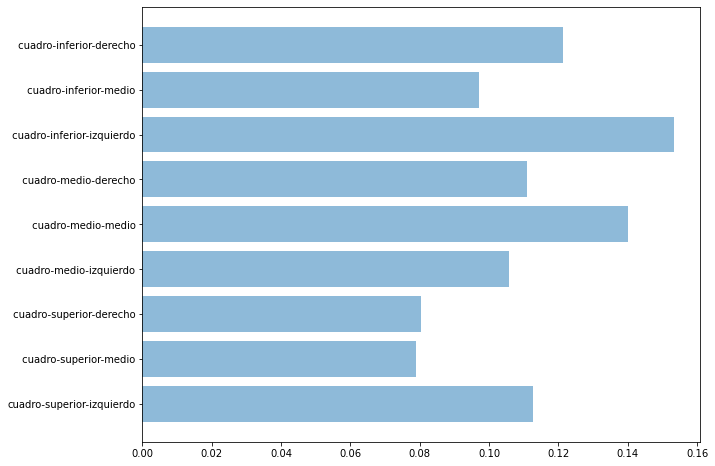

In [1742]:
prediccionADABosting.obtenerVariablesImportantes()

Para el algoritmo de potenciacion de ADA BOOSTING, podemos ver que la variable mas importante es el cuadro inferior izquierdo

In [1743]:
prediccionXGBoosting = PrediccionXGBoosting(datos=datosTicTacToe)
prediccionXGBoosting.entrenamiento(train_size=0.80)

[0.11106831 0.08060148 0.08199095 0.09962354 0.14000401 0.10164083
 0.15780867 0.11104057 0.11622163]


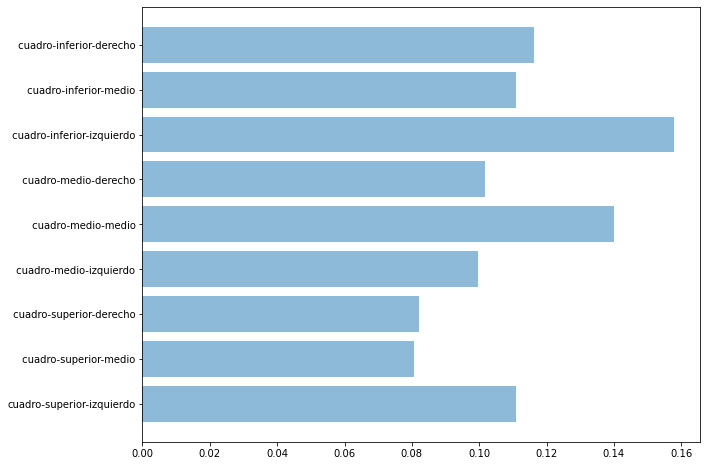

In [1744]:
prediccionXGBoosting.obtenerVariablesImportantes()

Para el algoritmo de potenciacion de XG BOOSTING, podemos ver que la variable mas importante es el cuadro inferior izquierdo

In [1745]:
prediccionRandomForest = PrediccionRandomForest(datos=datosTicTacToe)
prediccionRandomForest.entrenamiento(train_size=0.80)

[0.1336949  0.08313247 0.13065682 0.07490372 0.1418822  0.10285765
 0.10626768 0.11441025 0.1121943 ]


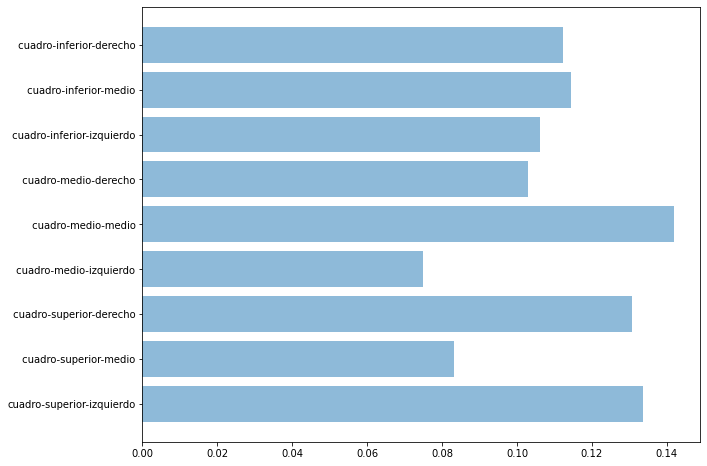

In [1746]:
prediccionRandomForest.obtenerVariablesImportantes()

Sin modificar ningun parametro podemos ver como el algorimo de bosques aleatorios por consenso, en este caso esta prediciendo mejor que los algoritmos por metodos de potenciación. Una cosa muy interesante con esto es que el metodo de concenso utiliza como variable mas importante el cuadro del medio medio, mientras que los otros no escogen esta variable como mas importante, si no que escogen las esquinas inferiores o superiores.

Ademas de que tiene una precision global mejor que los otros tambien tiene, la presicion positiva y la precision negativa, muy superior a las otras.


In [1747]:
reporteFinal = pd.concat([prediccionADABosting.reporte, prediccionXGBoosting.reporte, prediccionRandomForest.reporte])
reporteFinal


,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios ADA Boosting,0.890625,0.109375,115,56,3,18,0.756757,0.974576
0,Bosques Aleatorios XG Boosting,0.880208,0.119792,116,53,2,21,0.716216,0.983051
0,Bosques Aleatorios,0.901042,0.098958,112,61,6,13,0.824324,0.949153


In [1748]:
prediccionADABosting = PrediccionADABoosting(datos=datosTicTacToe)
prediccionADABosting.entrenamiento(train_size=0.80, criterion="entropy")

[0.15163459 0.08105742 0.08558643 0.09145865 0.10894556 0.11756226
 0.16244122 0.1069096  0.09440428]


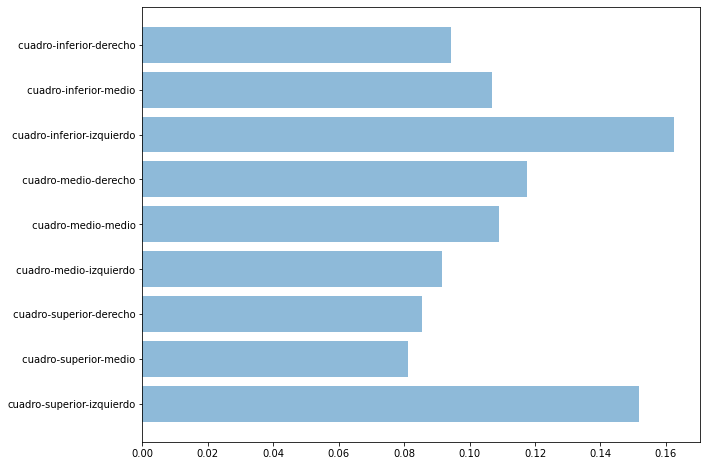

In [1749]:
prediccionADABosting.obtenerVariablesImportantes()

Para el algoritmo de potenciacion de ADA BOOSTING, podemos ver que la variable mas importante es el cuadro inferior izquierdo

In [1750]:
prediccionXGBoosting = PrediccionXGBoosting(datos=datosTicTacToe)
prediccionXGBoosting.entrenamiento(train_size=0.80, n_estimators=4)

[0.1113264  0.0824358  0.08385131 0.0997108  0.14000401 0.10037948
 0.15702623 0.10970575 0.1155602 ]


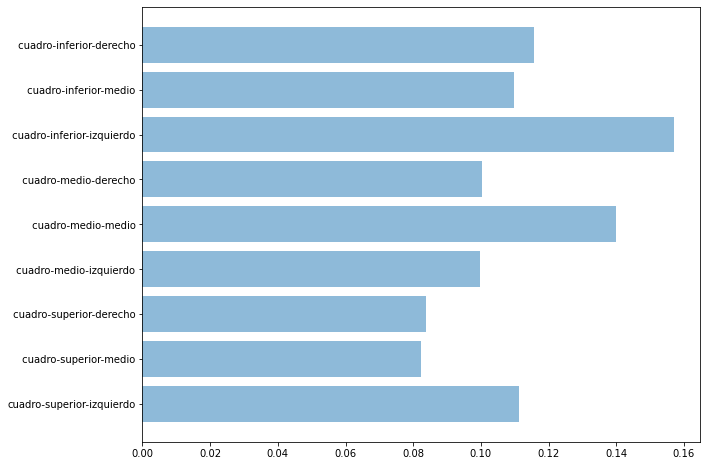

In [1751]:
prediccionXGBoosting.obtenerVariablesImportantes()

Para el algoritmo de potenciacion de XG BOOSTING, podemos ver que la variable mas importante es el cuadro inferior izquierdo

In [1752]:
prediccionRandomForest = PrediccionRandomForest(datos=datosTicTacToe)
prediccionRandomForest.entrenamiento(train_size=0.80, n_estimators=3)

[0.09947915 0.11671538 0.1129984  0.052559   0.16394741 0.12250118
 0.10459059 0.10185377 0.12535511]


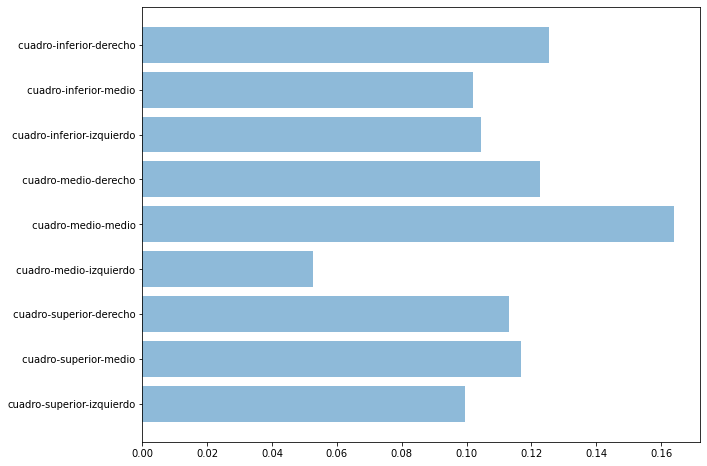

In [1753]:
prediccionRandomForest.obtenerVariablesImportantes()

En este caso cambiando los parametros, podemos ver que el algoritmo de ADA BOSTING si mejoro un poquito, lo que hice fue poner el parametro de la entriopia en lugar del otro que tenia que era GINI.

En el caso de Bosques Aleatorios XG Boosting lo que hice fue aumentar el numero de estimadores a 4, pero me parece sumamente interesante saber que no cambio casi nada con respecto a su predecesor

En el caso de Bosques Aleatorios, reduje la cantidad de estimadores y mas bien empeoro muchisimo antes estaba en 10 y ahora en 3

In [1754]:
reporteFinal = pd.concat([prediccionADABosting.reporte, prediccionXGBoosting.reporte, prediccionRandomForest.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios ADA Boosting,0.895833,0.104167,116,56,2,18,0.756757,0.983051
0,Bosques Aleatorios XG Boosting,0.880208,0.119792,117,52,1,22,0.702703,0.991525
0,Bosques Aleatorios,0.838542,0.161458,103,58,15,16,0.783784,0.872881


[0.02685367 0.11321789 0.00738241 0.03796637 0.25958745 0.07680108
 0.29662114 0.07367063 0.01720881 0.07551571 0.01330616 0.0018687 ]


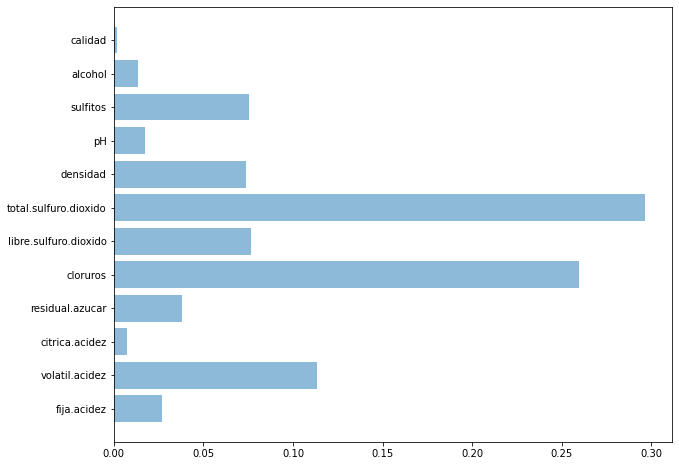

In [1755]:
datosWine = pd.read_csv("wine.csv")
prediccionRandomForest = PrediccionRandomForest(datosWine)
prediccionRandomForest.entrenamiento(train_size=0.75)
prediccionRandomForest.obtenerVariablesImportantes()


[            nan             nan             nan             nan
             nan             nan             nan             nan
             nan -2.97268777e-02             nan  8.91266404e-05]


/home/william/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:605: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


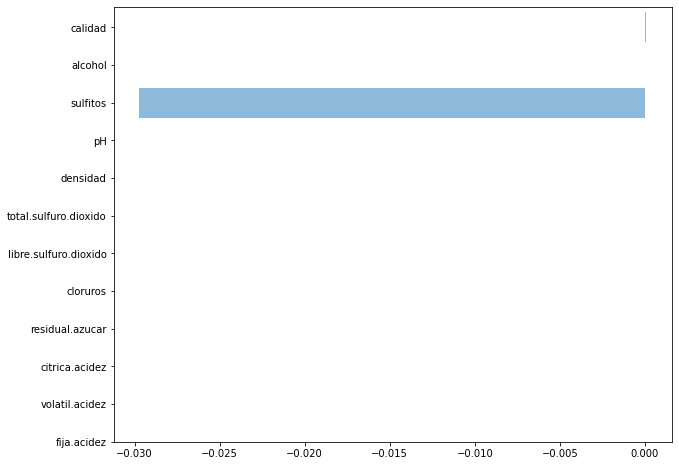

In [1756]:
prediccionADABoosting = PrediccionADABoosting(datosWine)
prediccionADABoosting.entrenamiento(train_size=0.75)
prediccionADABoosting.obtenerVariablesImportantes()

[0.00336954 0.04335976 0.00070099 0.01017999 0.20485135 0.00111279
 0.6836528  0.01768589 0.01188626 0.01531976 0.00545288 0.002428  ]


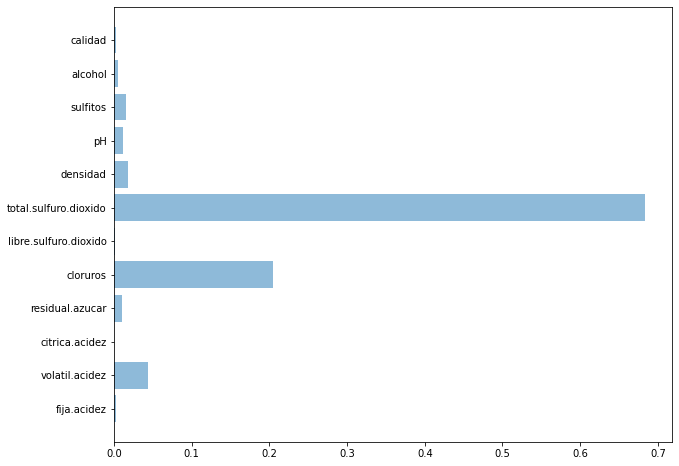

In [1757]:
prediccionXGBoosting = PrediccionXGBoosting(datosWine)
prediccionXGBoosting.entrenamiento(train_size=0.75)
prediccionXGBoosting.obtenerVariablesImportantes()

En este caso sin la edicion de los parametros por defectos podemos observar que el metodo de bosques aleatorios esta prediciendo muy bien, aunque en realidad todos estan prediciendo bien y eso se puede notar tanto en la precision global, como en la precision positiva, y en la precision negativa.


Sin embargo el de bosques aleatorios es superior por que es superior en todas las categorias, una cosa interesante es ver que la variable mas importante para esta clasificacion es la variable mas importante que es : total.sulfuro.dioxido.

In [1758]:
reporteFinal = pd.concat([prediccionRandomForest.reporte, prediccionADABoosting.reporte, prediccionXGBoosting.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios,0.995692,0.004308,392,1226,6,1,0.999185,0.984925
0,Bosques Aleatorios ADA Boosting,0.985231,0.014769,384,1217,14,10,0.991850,0.964824
0,Bosques Aleatorios XG Boosting,0.986462,0.013538,384,1219,14,8,0.993480,0.964824


[0.02692492 0.05411077 0.00666188 0.00869706 0.26046649 0.10432941
 0.27141338 0.07199092 0.03407895 0.14848632 0.00820879 0.00463112]


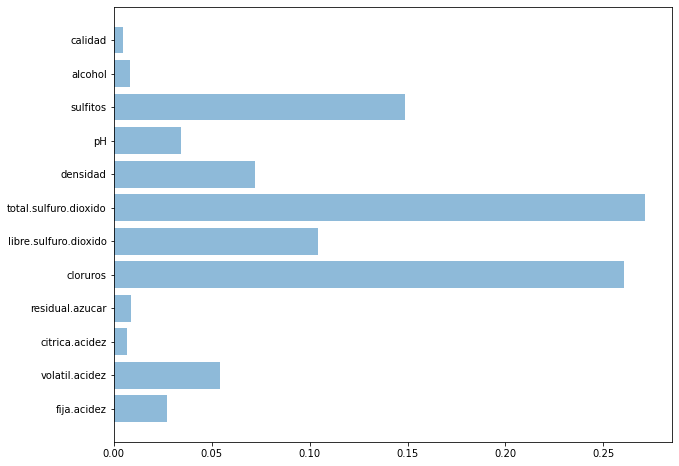

In [1759]:
datosWine = pd.read_csv("wine.csv")
prediccionRandomForest = PrediccionRandomForest(datosWine)
prediccionRandomForest.entrenamiento(train_size=0.75, n_estimators=3)
prediccionRandomForest.obtenerVariablesImportantes()


[        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan -0.63409776]


/home/william/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:605: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


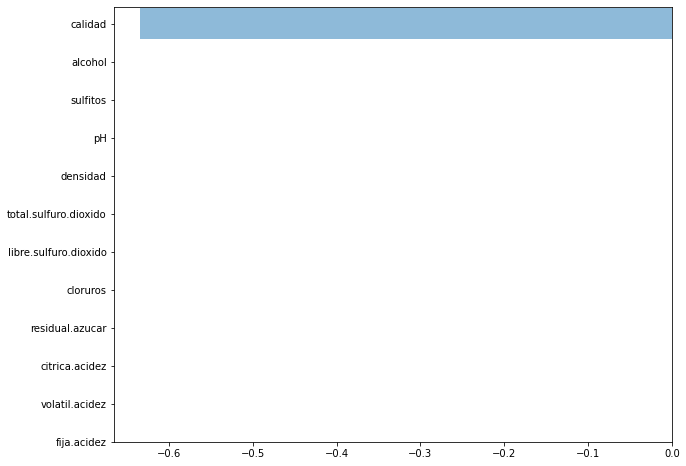

In [1760]:
prediccionADABoosting = PrediccionADABoosting(datosWine)
prediccionADABoosting.entrenamiento(train_size=0.75, criterion="entropy")
prediccionADABoosting.obtenerVariablesImportantes()

[2.79751541e-03 4.36229861e-02 6.74091602e-04 1.02639864e-02
 2.04593498e-01 9.15225390e-04 6.83701832e-01 1.72516770e-02
 1.41765906e-02 1.47990599e-02 5.54741478e-03 1.65612254e-03]


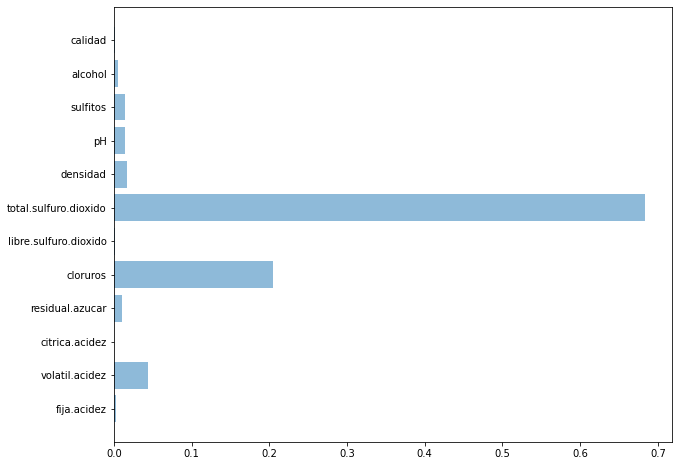

In [1761]:
prediccionXGBoosting = PrediccionXGBoosting(datosWine)
prediccionXGBoosting.entrenamiento(train_size=0.75, n_estimators=4)
prediccionXGBoosting.obtenerVariablesImportantes()

En este caso empeoro  los modelos de Bosques Aleatorios ADA Boosting y  Bosques Aleatorios, pero el modelo de Bosques Aleatorios XG Boosting si tuvo una mejoria con incrementar los estimadores.

In [1762]:
reporteFinal = pd.concat([prediccionRandomForest.reporte, prediccionADABoosting.reporte, prediccionXGBoosting.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios,0.990769,0.009231,389,1221,9,6,0.995110,0.977387
0,Bosques Aleatorios ADA Boosting,0.991385,0.008615,388,1223,10,4,0.996740,0.974874
0,Bosques Aleatorios XG Boosting,0.988308,0.011692,384,1222,14,5,0.995925,0.964824


[0.11502631 0.24157823 0.47221399 0.06931385 0.04195616 0.05991145]


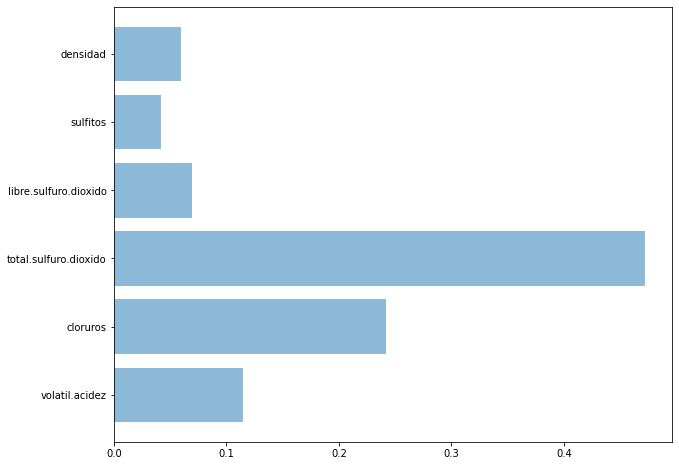

In [1763]:

datosWine = pd.DataFrame(datosWine, columns=["volatil.acidez", "cloruros", "total.sulfuro.dioxido",
                                             "libre.sulfuro.dioxido", "sulfitos", "densidad", "tipo"])
prediccionRandomForest = PrediccionRandomForest(datosWine)
prediccionRandomForest.entrenamiento(train_size=0.75)
prediccionRandomForest.obtenerVariablesImportantes()


[             nan              nan              nan              nan
 -1.01923304e+123              nan]


/home/william/PycharmProjects/pythonProject/venv/lib/python3.8/site-packages/sklearn/tree/_classes.py:605: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


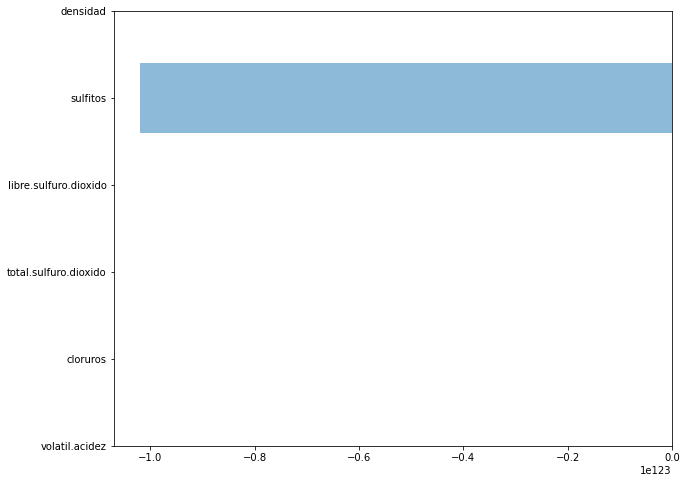

In [1764]:
prediccionADABoosting = PrediccionADABoosting(datosWine)
prediccionADABoosting.entrenamiento(train_size=0.75)
prediccionADABoosting.obtenerVariablesImportantes()

[0.05664425 0.20017855 0.69325324 0.00542984 0.02454945 0.01994467]


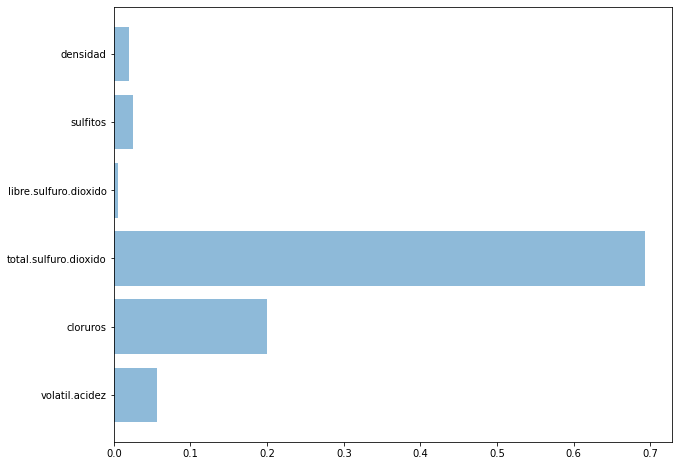

In [1765]:
prediccionXGBoosting = PrediccionXGBoosting(datosWine)
prediccionXGBoosting.entrenamiento(train_size=0.75)
prediccionXGBoosting.obtenerVariablesImportantes()

In [1766]:
reporteFinal = pd.concat([prediccionRandomForest.reporte, prediccionADABoosting.reporte, prediccionXGBoosting.reporte])
reporteFinal

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios,0.991385,0.008615,387,1224,11,3,0.997555,0.972362
0,Bosques Aleatorios ADA Boosting,0.972308,0.027692,375,1205,23,22,0.982070,0.942211
0,Bosques Aleatorios XG Boosting,0.988308,0.011692,386,1220,12,7,0.994295,0.969849


Ciertamente cuando se usan las 6 variables mas importantes empeoran los resultados de la precision global pero ciertamente esto significa que sea peor, por que si vemos las precisiones especificas  negativas, vamos a ver que en realidad los todos los valores incrementaron y en las positivas el valor del XG, incremento, en las otras ADA y Bosques decremento el valor.

In [1767]:

class ConsensoPropio:
    def __init__(self, datos):
        self.__datos = datos
        self.__modelo = {}

    @property
    def modelo(self):
        return self.__modelo

    def generarListaDeRandomIndex(self):
        listaElementosAleatorios = []
        for x in range(0, self.__datos.shape[0] - 1):
            listaElementosAleatorios.append(randint(0, self.__datos.shape[0] - 1))
        return listaElementosAleatorios

    def llenar(self):
        muestra = []
        seleccionRandom = self.generarListaDeRandomIndex()
        for x in seleccionRandom:
            muestra.append(self.__datos.iloc[x])
        return pd.DataFrame(muestra).drop_duplicates(subset=["Unnamed: 0"])

    def fit(self):
        prediccionADABosting = PrediccionADABoosting(datos=self.llenar())
        prediccionXGBoosting = PrediccionXGBoosting(datos=self.llenar())
        prediccionRandomForest = PrediccionRandomForest(datos=self.llenar())
        prediccionKNeighbors = PrediccionKNeighbors(datos=self.llenar())

        prediccionADABosting.entrenamiento(entretenamiento="ADA Bosting")
        prediccionXGBoosting.entrenamiento(entrenamiento="XG Bosting")
        prediccionRandomForest.entrenamiento(entrenamiento="Random Forest")
        prediccionKNeighbors.entrenamiento()
        self.__modelo = pd.concat(
            [prediccionADABosting.reporte.join(pd.DataFrame({"instancia": [prediccionADABosting.instancia]})),
             prediccionXGBoosting.reporte.join(pd.DataFrame({"instancia": [prediccionXGBoosting.instancia]})),
             prediccionRandomForest.reporte.join(pd.DataFrame({"instancia": [prediccionRandomForest.instancia]})),
             prediccionKNeighbors.reporte.join(pd.DataFrame({"instancia": [prediccionKNeighbors.instancia]}))]).sort_values('Precision Global', ascending=False)

    def predict(self,x_test):
        print("El modelo es: ", self.__modelo.iloc[0].Modelo)
        return self.__modelo.iloc[0].instancia.predict(x_test)


probabilidad = pd.read_csv("potabilidad_V2.csv")
consensoPropio = ConsensoPropio(probabilidad)
consensoPropio.fit()

In [1768]:
x = probabilidad.iloc[:, :-1]
y = probabilidad.iloc[:, -1]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.80, random_state=0)


class Analisis:
    def __init__(self):
        self.__reporte = 0
        self.__precisionGlobal =0
        self.__precision_category =0
        self.__error_global  = 0

    @property
    def reporte(self):
        return  self.__reporte

    def generacionReporte(self, nombreDelModelo):
        dict = {
            "Modelo": [nombreDelModelo],
            "Precision Global": [self.__precisionGlobal],
            "Error Global": [self.__error_global]}
        self.__reporte = pd.DataFrame(dict).join(self.__precision_category)

    def analsis(self, MC):
        self.__precisionGlobal = np.sum(MC.diagonal()) / np.sum(MC)
        self.__precision_category = pd.DataFrame(MC.diagonal() / np.sum(MC, axis=1)).T
        self.__error_global = 1 - self.__precisionGlobal
        self.__precision_category.columns = ["Precision Positiva (PP)", "Precision Negativa (PN)"]
        self.generacionReporte("Consenso Propio")
        return {"Matriz de Confusión": MC,
                "Precisión Global": self.__precisionGlobal,
                "Error Global": self.__error_global,
                "Precisión por categoría": self.__precision_category}

prediccion = consensoPropio.predict(x_test)
MC = confusion_matrix(y_test, prediccion)
analizador = Analisis()
indices = analizador.analsis(MC)
for k in indices:
    print("\n%s:\n%s" % (k, str(indices[k])))


El modelo es:  XG Bosting

Matriz de Confusión:
[[251   1]
 [  0 151]]

Precisión Global:
0.9975186104218362

Error Global:
0.002481389578163795

Precisión por categoría:
   Precision Positiva (PP)  Precision Negativa (PN)
0                 0.996032                      1.0


In [1769]:
randomForest = PrediccionRandomForest(datos=probabilidad)
randomForest.entrenamiento(n_estimators=4)
randomForest.reporte

,Modelo,Precision Global,Error Global,Verdaderos Positivos,Verdaderos Negativos,Falsos Negativos,Falsos Positivos,Precision Positiva (PP),Precision Negativa (PN)
0,Bosques Aleatorios,0.71173,0.28827,76,282,118,27,0.912621,0.391753


In [1770]:
analizador.reporte

,Modelo,Precision Global,Error Global,Precision Positiva (PP),Precision Negativa (PN)
0,Consenso Propio,0.997519,0.002481,0.996032,1.0


El metodo de Consenso Propio tiene una amplia ventaja sobre el otro metodo, en todos los sentidos